In [1]:
import sys
import cv2
import os
import numpy as np

from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp

print('deep learning modules imported')


/Users/npaul/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


deep learning modules imported


# Image Loading

In [2]:
IMG_PATH = '/Users/npaul/Documents/git/face-dl/data/'

def loadImage(path, output=sys.stdout):
    image = cv2.imread(path)
    if image is None:
        print("Unable to load image '%s'" % path, file=output)
        return None
    image = image.astype("float") / 255.0
    image = img_to_array(image)

    return image

In [3]:
img = loadImage(os.path.join(IMG_PATH, 's1', '1.pgm'))
print(img.shape)
img = np.rollaxis(img, 0, 3)  
print(img.shape)
img = np.rollaxis(img, 0, 3)
img = np.rollaxis(img, 0, 3)
print(img.shape)

(3, 112, 92)
(112, 92, 3)
(3, 112, 92)


In [4]:
import matplotlib.pyplot as plt

def previewImage(image, title=None):
    plt.figure()
    im = np.transpose(image, (1,2,0))
    #im = image
    rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
    plt.imshow(rgb)
    if title is not None:
        plt.title(title)
    plt.show()

In [5]:
from random import randint

all_imgs = os.listdir(IMG_PATH)

def randImg():
    return all_imgs[randint(0, len(all_imgs))]

In [6]:
def imagePaths():
    imgs = {}

    for dir in os.listdir(IMG_PATH):
        path = os.path.join(IMG_PATH, dir)
        if os.path.isdir(path):
            imgs[dir] = []
            for f in os.listdir(path):
                imgs[dir].append(os.path.join(path, f))
    return imgs

In [7]:
image_paths = imagePaths()
image_paths.keys()

dict_keys(['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9'])

# Load and Organize Data

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

def loadAllImages(do_shuffle=False, split=False, random_state=0, output=sys.stdout):
    """
    X, y = loadAllImages()
    X: image data
    y: labels
    """
    data = {}

    image_paths = imagePaths()

    labels = []
    imgs = []
    for k,paths in image_paths.items():
        for p in paths:
            labels.append(k)
            imgs.append(loadImage(p))
            
    X, y = np.array(imgs), labels        
    
    if do_shuffle:
        X, y = shuffle(X, y, random_state=random_state)
    
    data['class_names'] = sorted(list(set(labels))) 
    data['num_classes'] = len(data['class_names'])
    # shape is (C,h,w) => (w,h)
    data['image_size']  = (X[0].shape[2], X[0].shape[1])

    # 'sXX' -> N
    y = [int(s[1:])-1 for s in y]
    
    y = np_utils.to_categorical(y, data['num_classes'])
        
    
    if split:
        # Split data
        # 75% Train
        # 12.5% Validation (Dev)
        # 12.5% Test

        # partition the data into training and testing splits using 75% of
        # the data for training and the remaining 25% for testing and validataion
        (X_train, X_test_val, y_train, y_test_val) = train_test_split(X,
            y, test_size=0.25, random_state=0)

        # Split test_val into testing and validation sets 50/50
        (X_test, X_val, y_test, y_val) = train_test_split(
            X_test_val, y_test_val, test_size=0.5, random_state=0)

        print('Training set size: %d' % len(y_train), file=output)
        print('Test set size: %d' % len(y_test), file=output)
        print('Validation set size: %d' % len(y_val), file=output)

        data['X_train'] = X_train
        data['X_test'] = X_test
        data['X_val'] = X_val
        data['y_train'] = y_train
        data['y_test'] = y_test
        data['y_val'] = y_val
    else:
        data['X'] = X
        data['y'] = y
        
    return data

# Image Cropping

In [9]:
from random import randint

def cropImage(img, w, h, kind='ul'):
    #print(img.shape)
    
    # (C,h,w) => (h,w,C)
    img = np.rollaxis(img, 0, 3)
    
    W = img.shape[1]
    H = img.shape[0]
    
    if kind == 'ul':
        cropped = img[0:0+h, 0:0+w]
    elif kind == 'll':
        cropped = img[H-h:H, 0:0+w]
    elif kind == 'ur':
        cropped = img[0:0+h, W-w:W]
    elif kind == 'lr':
        cropped = img[H-h:H, W-w:W]
    elif kind == 'rand':
        x = randint(0, H-h)
        y = randint(0, W-w)
        cropped = img[x:x+h, y:y+w]
    else:
        raise ValueError("Invalid argument for 'kind': %s" + str(kind)) 
        
    # (h,w,C) => (C,h,w)
    cropped = np.rollaxis(cropped, 0, 3)
    cropped = np.rollaxis(cropped, 0, 3)
    
    return cropped

In [10]:
import matplotlib.pyplot as plt
from random import randint

def preview_data(name, X_train, y_train, class_names, width=5, height=5, save=False, show=False):
    unique_imgs = 3
    offset = randint(0,len(y_train[0]) - (1 + unique_imgs)) 
    count = width * height
    fig = plt.figure(figsize=(width*1.7,height*2))
    
    def nextimg():
        label = offset + randint(0,unique_imgs-1)
        n = randint(0, len(y_train)-1)
        return label, n
    
    for i in range(count):
        label, n = nextimg()
        while int(np.argmax(y_train[n])) != label:
            label, n = nextimg()
            
        ax = fig.add_subplot(height,width,i+1, xticks=[], yticks=[])
        im = X_train[n,::]
        im = np.transpose(im, (1,2,0))
        rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
        plt.imshow(rgb)
        ax.set_title('%s : %d' % (class_names[int(np.argmax(y_train[n]))], n))
    
    plt.suptitle(name)
    if save:
        plt.savefig('plots/preview_%s.png' % name)
    if show:
        plt.show()
        
print('preview_data')

preview_data


Training set size: 300
Test set size: 50
Validation set size: 50


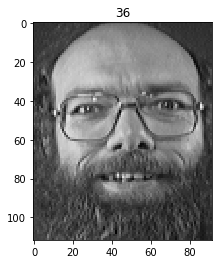

In [11]:
from time import time

data = loadAllImages(do_shuffle=True, random_state=int(time()), split=True)
X = data['X_train']
y = data['y_train']
test_image = X[2]
previewImage(test_image, title=np.argmax(y[2]))

num_classes: 40
image_size: (92, 112)
class_names: ['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


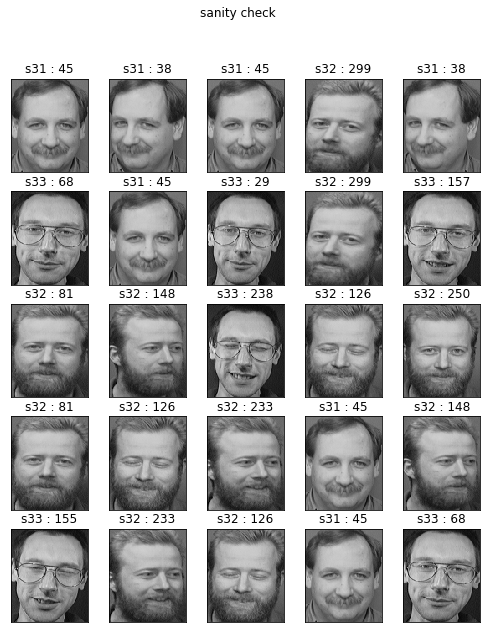

In [12]:
for k in ['num_classes', 'image_size', 'class_names']:
    print('%s: %s' % (k, data[k]))
    
preview_data('sanity check', data['X_train'], data['y_train'], data['class_names'], show=True)

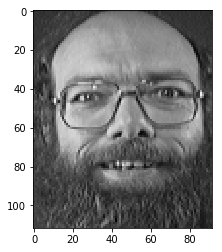

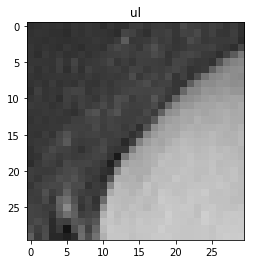

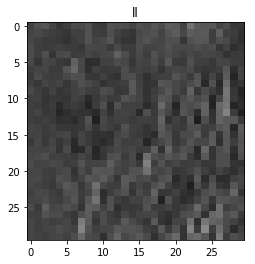

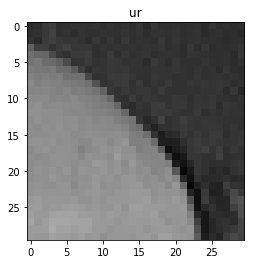

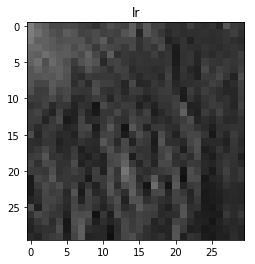

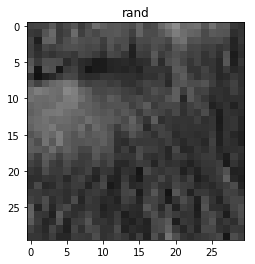

In [13]:
previewImage(test_image)
for kind in ['ul', 'll', 'ur', 'lr', 'rand']:
    previewImage(cropImage(test_image, 30, 30, kind), title=kind)

In [14]:
# The Network

In [15]:
# Define the LeNet Model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
 
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
        
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model
    
print('LeNet model defined')

LeNet model defined


In [16]:
def train_model(name, trainX, trainY, valX, valY, num_classes, img_size, epochs, batch_size=45, init_lr=1e-3, output=sys.stdout):
    aug = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")
    
    # initialize the model
    print("[INFO] building model '%s' ..." % name, file=output)
    model = LeNet.build(width=img_size[0],
                        height=img_size[1],
                        depth=3,
                        classes=num_classes)
    
    print(model.summary())
    
    loss = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
    
    print("[INFO] compiling model '%s' ..." % name, file=output)
    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=["accuracy"])
    
    trainY_idx = np.arange(len(trainY[0]))

    # train the network
    steps_per_epoch = len(trainX) // batch_size
    print('Steps per epoch:', steps_per_epoch)
    print("[INFO] training network...", file=output)
    H = model.fit_generator(aug.flow(trainX, trainY),
                            validation_data=(valX, valY),
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs, verbose=1)

    # save the model to disk
    print("[INFO] serializing network...", file=output)
    save_path = 'models/%s.model' % name
    print("Saving model as ./%s" % save_path, file=output)
    model.save(save_path)
    
    return H, model

print('train_model_weighted')

train_model_weighted


epochs = 2
history, model = train_model('sample',
                data['X_train'],
                data['y_train'],
                data['X_val'],
                data['y_val'],
                data['num_classes'],
                data['image_size'],
                epochs) #epochs

# Evaluation

In [17]:
# plot the training loss and accuracy
def plot_training_history(name, H, epochs, save=False, show=False):
    plt.figure()
    N = epochs
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on classes")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    if save:
        plt.savefig('plots/validation_history_%s.png' % name)
    if show:
        plt.show()

print('plot_history()')

plot_history()


In [18]:
#plot_training_history('test', history, epochs, show=True)

In [19]:
def run_test(data, model, f=sys.stdout):
    score = model.evaluate(data['X_test'], data['y_test'])
    print('Loss on test data: %s' % score[0], file=f)
    print('Accuracy on test data: %s' % score[1], file=f)

    y_pred = model.predict(data['X_test'])

    # prediction data
    num_correct = np.sum(np.argmax(data['y_test'], axis=1) == np.argmax(y_pred, axis=1))
    #print(data['y_test'])
    #print(y_pred)
    print('Correct / Total: %d/%d' % (num_correct, len(data['y_test'])), file=f)
    
    data['y_pred'] = y_pred

In [20]:
#run_test(data, model)

In [21]:
def preview_predicted_data(name, X_test, y_truth, y_pred, class_names, width=5, height=5, save=False, show=False):
    count = width * height
    if len(X_test) < count:
        count = X_test
        height = 2
        width = count // 2
        
    fig = plt.figure(figsize=(width*1.7,height*2))
    for i in range(count):
        n = randint(0,len(y_truth)-1)
        ax = fig.add_subplot(height,width,i+1, xticks=[], yticks=[])
        im = X_test[n,::]
        im = np.transpose(im, (1,2,0))
        rgb = np.fliplr(im.reshape(-1,3)).reshape(im.shape)
        plt.imshow(rgb)
        #if y_truth[n] == y_pred[n]:
        #    title = class_names[int(np.argmax(y_truth[n]))]
        #else:
        title = '%s/%s' % (class_names[int(np.argmax(y_pred[n]))], class_names[int(np.argmax(y_truth[n]))])
        ax.set_title(title)
    
    plt.suptitle('%s: predicted / correct' % name)
    if save:
        plt.savefig('plots/preview_%s.png' % name)
    if show:
        plt.show()
        
print('preview_data')

preview_data


In [22]:
#preview_predicted_data('test', data['X_test'], data['y_test'], data['y_pred'], data['class_names'], show=True)

In [23]:
def quickTest(name, data, epochs):
    history, model = train_model(name,
                    data['X_train'],
                    data['y_train'],
                    data['X_val'],
                    data['y_val'],
                    data['num_classes'],
                    data['image_size'],
                    epochs) #epochs
    
    plot_training_history(name, history, epochs, show=True)
    
    # creates data['y_pred']
    run_test(data, model)
    
    preview_predicted_data('test', 
                           data['X_test'], 
                           data['y_test'], 
                           data['y_pred'], 
                           data['class_names'], 
                           show=True)
    

In [24]:
#quickTest('test', data, 2)

In [25]:
#quickTest('test', data, 40)

In [26]:
def cropData(data, w, h, kind='ur'):
    data_cropped = dict(data)
    
    for k in ['X_train', 'X_val', 'X_test']:
        cropped = []
        for i in range(len(data[k])):
            cropped.append(cropImage(data[k][i], w, h, kind))

        data_cropped[k] = np.array(cropped)
    
    data_cropped['image_size'] = (w,h)
    
    return data_cropped

[INFO] building model 'crop_60x60_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 60, 60)        1520      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 60, 60)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 30, 30)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 30, 30)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 15, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None

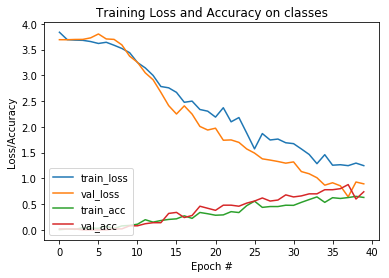

50/50 [==============================] - 1s 15ms/step
Loss on test data: 0.8803854012489318
Accuracy on test data: 0.7000000047683715
Correct / Total: 35/50


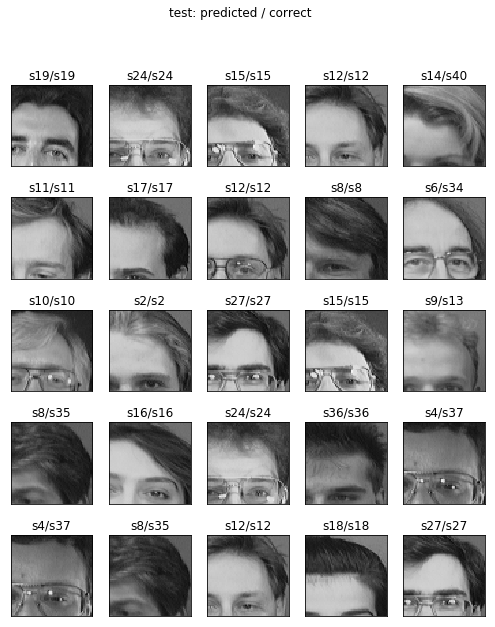

In [27]:
quickTest('crop_60x60_ur', cropData(data, 60, 60, kind='ur'), 40)

[INFO] building model 'crop_30x30_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 30, 30)        1520      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 30, 30)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 15, 15)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 15, 15)        25050     
_________________________________________________________________
activation_6 (Activation)    (None, 50, 15, 15)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None

Epoch 49/70
6/6 [==============================] - 1s 202ms/step - loss: 1.0065 - acc: 0.6494 - val_loss: 1.1632 - val_acc: 0.6000
Epoch 50/70
6/6 [==============================] - 1s 209ms/step - loss: 1.0504 - acc: 0.6615 - val_loss: 1.2233 - val_acc: 0.6000
Epoch 51/70
6/6 [==============================] - 1s 189ms/step - loss: 0.9679 - acc: 0.6663 - val_loss: 1.1148 - val_acc: 0.6000
Epoch 52/70
6/6 [==============================] - 1s 212ms/step - loss: 1.1748 - acc: 0.6458 - val_loss: 1.1413 - val_acc: 0.6600
Epoch 53/70
6/6 [==============================] - 1s 191ms/step - loss: 1.1158 - acc: 0.6663 - val_loss: 1.0517 - val_acc: 0.6600
Epoch 54/70
6/6 [==============================] - 2s 250ms/step - loss: 0.8071 - acc: 0.7552 - val_loss: 1.2305 - val_acc: 0.6200
Epoch 55/70
6/6 [==============================] - 1s 237ms/step - loss: 0.8770 - acc: 0.7331 - val_loss: 1.1113 - val_acc: 0.6000
Epoch 56/70
6/6 [==============================] - 1s 196ms/step - loss: 0.7778 - a

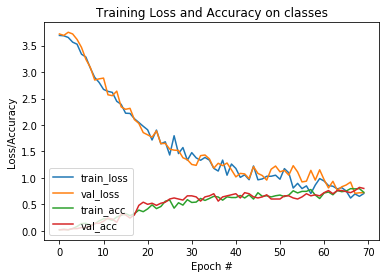

50/50 [==============================] - 0s 3ms/step
Loss on test data: 0.6761191987991333
Accuracy on test data: 0.7800000047683716
Correct / Total: 39/50


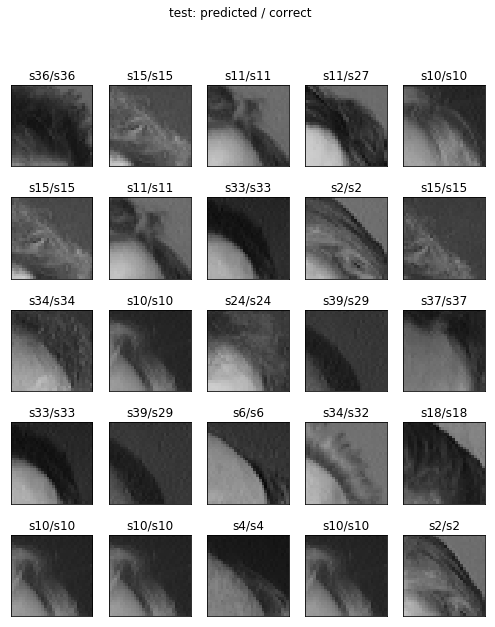

In [28]:
quickTest('crop_30x30_ur', cropData(data, 30, 30, kind='ur'), 70)

[INFO] building model 'crop_10x10_ur' ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 10, 10)        1520      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 10, 10)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 5, 5)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 5, 5)          25050     
_________________________________________________________________
activation_10 (Activation)   (None, 50, 5, 5)          0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 2, 2)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None

6/6 [==============================] - 0s 31ms/step - loss: 2.5596 - acc: 0.1610 - val_loss: 2.6142 - val_acc: 0.2800
Epoch 49/120
6/6 [==============================] - 0s 42ms/step - loss: 2.5767 - acc: 0.1483 - val_loss: 2.7047 - val_acc: 0.1400
Epoch 50/120
6/6 [==============================] - 0s 29ms/step - loss: 2.5267 - acc: 0.1562 - val_loss: 2.9585 - val_acc: 0.2200
Epoch 51/120
6/6 [==============================] - 0s 35ms/step - loss: 2.4205 - acc: 0.1927 - val_loss: 2.6051 - val_acc: 0.2600
Epoch 52/120
6/6 [==============================] - 0s 47ms/step - loss: 2.5916 - acc: 0.1430 - val_loss: 2.7411 - val_acc: 0.1600
Epoch 53/120
6/6 [==============================] - 0s 26ms/step - loss: 2.3257 - acc: 0.2055 - val_loss: 2.6348 - val_acc: 0.2000
Epoch 54/120
6/6 [==============================] - 0s 30ms/step - loss: 2.2366 - acc: 0.2637 - val_loss: 2.6087 - val_acc: 0.1800
Epoch 55/120
6/6 [==============================] - 0s 29ms/step - loss: 2.3296 - acc: 0.2396 - 

6/6 [==============================] - 0s 27ms/step - loss: 1.7282 - acc: 0.3739 - val_loss: 2.3854 - val_acc: 0.3400
Epoch 111/120
6/6 [==============================] - 0s 31ms/step - loss: 1.7891 - acc: 0.3845 - val_loss: 2.5637 - val_acc: 0.2000
Epoch 112/120
6/6 [==============================] - 0s 33ms/step - loss: 1.8840 - acc: 0.2865 - val_loss: 2.3181 - val_acc: 0.3600
Epoch 113/120
6/6 [==============================] - 0s 32ms/step - loss: 1.7881 - acc: 0.3698 - val_loss: 2.3502 - val_acc: 0.3800
Epoch 114/120
6/6 [==============================] - 0s 43ms/step - loss: 1.8086 - acc: 0.3629 - val_loss: 2.4652 - val_acc: 0.2600
Epoch 115/120
6/6 [==============================] - 0s 28ms/step - loss: 1.8341 - acc: 0.3125 - val_loss: 2.4250 - val_acc: 0.3200
Epoch 116/120
6/6 [==============================] - 0s 34ms/step - loss: 1.7844 - acc: 0.3438 - val_loss: 2.4326 - val_acc: 0.2600
Epoch 117/120
6/6 [==============================] - 0s 29ms/step - loss: 1.8007 - acc: 0.

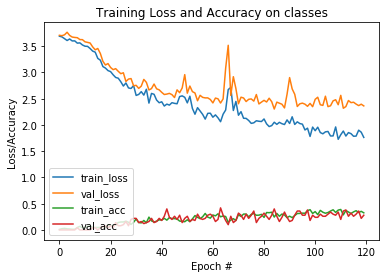

50/50 [==============================] - 0s 562us/step
Loss on test data: 2.1776516532897947
Accuracy on test data: 0.32000000059604644
Correct / Total: 16/50


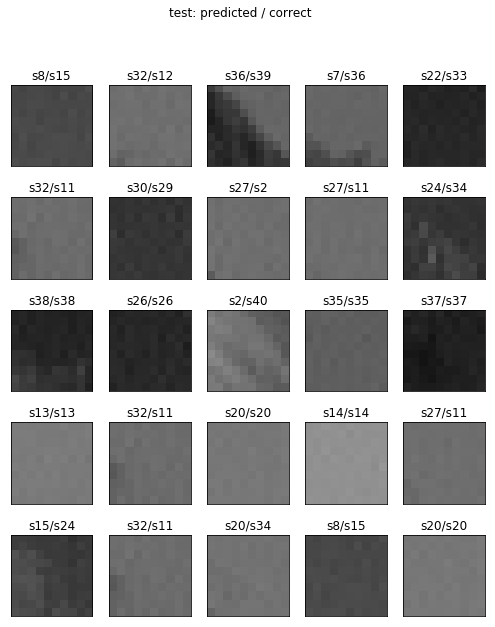

In [29]:
quickTest('crop_10x10_ur', cropData(data, 10, 10, kind='ur'), 120)